In [3]:
from torch import nn
from torch.nn.functional import relu
import torch
import os
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from lib.models import Gandalf
from lib.utils import *

from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [4]:
folds = get_leave_one_out_cv_ids_for_ekyn()
criterion = torch.nn.CrossEntropyLoss()
y_trues = []
y_preds = []

for FOLD,(train_ids,test_ids) in tqdm(enumerate(folds)):
    model = Gandalf()
    model.load_state_dict(torch.load(f=f'{GANDALFS_PATH}/gandalf_{FOLD}/best_model.pt',map_location='cpu',weights_only=False))
    model.to(DEVICE)
    for condition in ['Vehicle','PF']:
        X,y = load_eeg_label_pair(id=test_ids[0],condition=condition,zero_pad=False)
        testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
        loss,y_true,y_pred = evaluate(testloader,model,criterion,'cuda')
        y_trues.append(y_true)
        y_preds.append(y_pred)

0it [00:00, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 270/270 [00:11<00:00, 23.75it/s]
16it [05:53, 22.11s/it]


In [ ]:
FOLD = 1

folds = get_leave_one_out_cv_ids_for_ekyn()
train_ids,test_ids = folds[FOLD]
X,y = load_eeg_label_pair(id=test_ids[0],condition='PF',zero_pad=False)
testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
print(f'testloader: {len(testloader)} batches')

model = Gandalf()
model.load_state_dict(torch.load(f=f'{GANDALFS_PATH}/gandalf_{FOLD}/best_model.pt',map_location='cpu',weights_only=False))
model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
loss,y_true,y_pred = evaluate(testloader,model,criterion,'cuda')
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
report = classification_report(y_true,y_pred,output_dict=True)

In [9]:
device = 'cuda'
model.eval()
model.to(device)
with torch.no_grad():
    loss_total = 0
    y_true = []
    y_pred = []
    y_logits = []
    for Xi,yi in tqdm(testloader):
        Xi,yi = Xi.to(device),yi.to(device)
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss_total += loss.item()

        y_true.append(yi.argmax(axis=1).cpu())
        y_logits.append(logits)
        y_pred.append(logits.softmax(dim=1).argmax(axis=1).cpu())

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
y_logits = torch.cat(y_logits).cpu()
y_p = torch.where(y_true == 0)[0]
y_s = torch.where(y_true == 1)[0]
y_w = torch.where(y_true == 2)[0]
idx = torch.cat([y_p[torch.randperm(len(y_p))[:1024]],y_s[torch.randperm(len(y_s))[:1024]],y_w[torch.randperm(len(y_w))[:1024]]])
from sklearn.manifold import TSNE
import pandas as pd
tsne = TSNE(init='pca')
X = tsne.fit_transform(y_logits[idx])
tsne_df = pd.DataFrame(X)
tsne_df['y'] = y_true[idx]
tsne_df = tsne_df.sort_values(by='y')
tsne_df.loc[tsne_df['y'] == 2,'y'] = 'W'
tsne_df.loc[tsne_df['y'] == 1,'y'] = 'S'
tsne_df.loc[tsne_df['y'] == 0,'y'] = 'P'


100%|██████████| 270/270 [00:11<00:00, 24.32it/s]
/tmp/ipykernel_1060234/71217729.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'W' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tsne_df.loc[tsne_df['y'] == 2,'y'] = 'W'


In [5]:
reports = []
for (y_true,y_pred) in zip(y_trues,y_preds):
    reports.append(classification_report(y_true,y_pred,output_dict=True))

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Construct the DataFrame in wide format first
wide_df = pd.DataFrame({
    'precision': [report['macro avg']['precision'] for report in reports],
    'recall': [report['macro avg']['recall'] for report in reports],
    'f1-score': [report['macro avg']['f1-score'] for report in reports]
})

# wide_df = wide_df.drop([11,28])

# Use melt to convert the wide DataFrame into long format
long_df = wide_df.melt(var_name='metric', value_name='value')

/tmp/ipykernel_1060234/2050710055.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(labels=['P','S','W'])
/tmp/ipykernel_1060234/2050710055.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_yticklabels(labels=['P','S','W'])
/tmp/ipykernel_1060234/2050710055.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(labels=['P','S','W'])
/tmp/ipykernel_1060234/2050710055.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,1].legend()


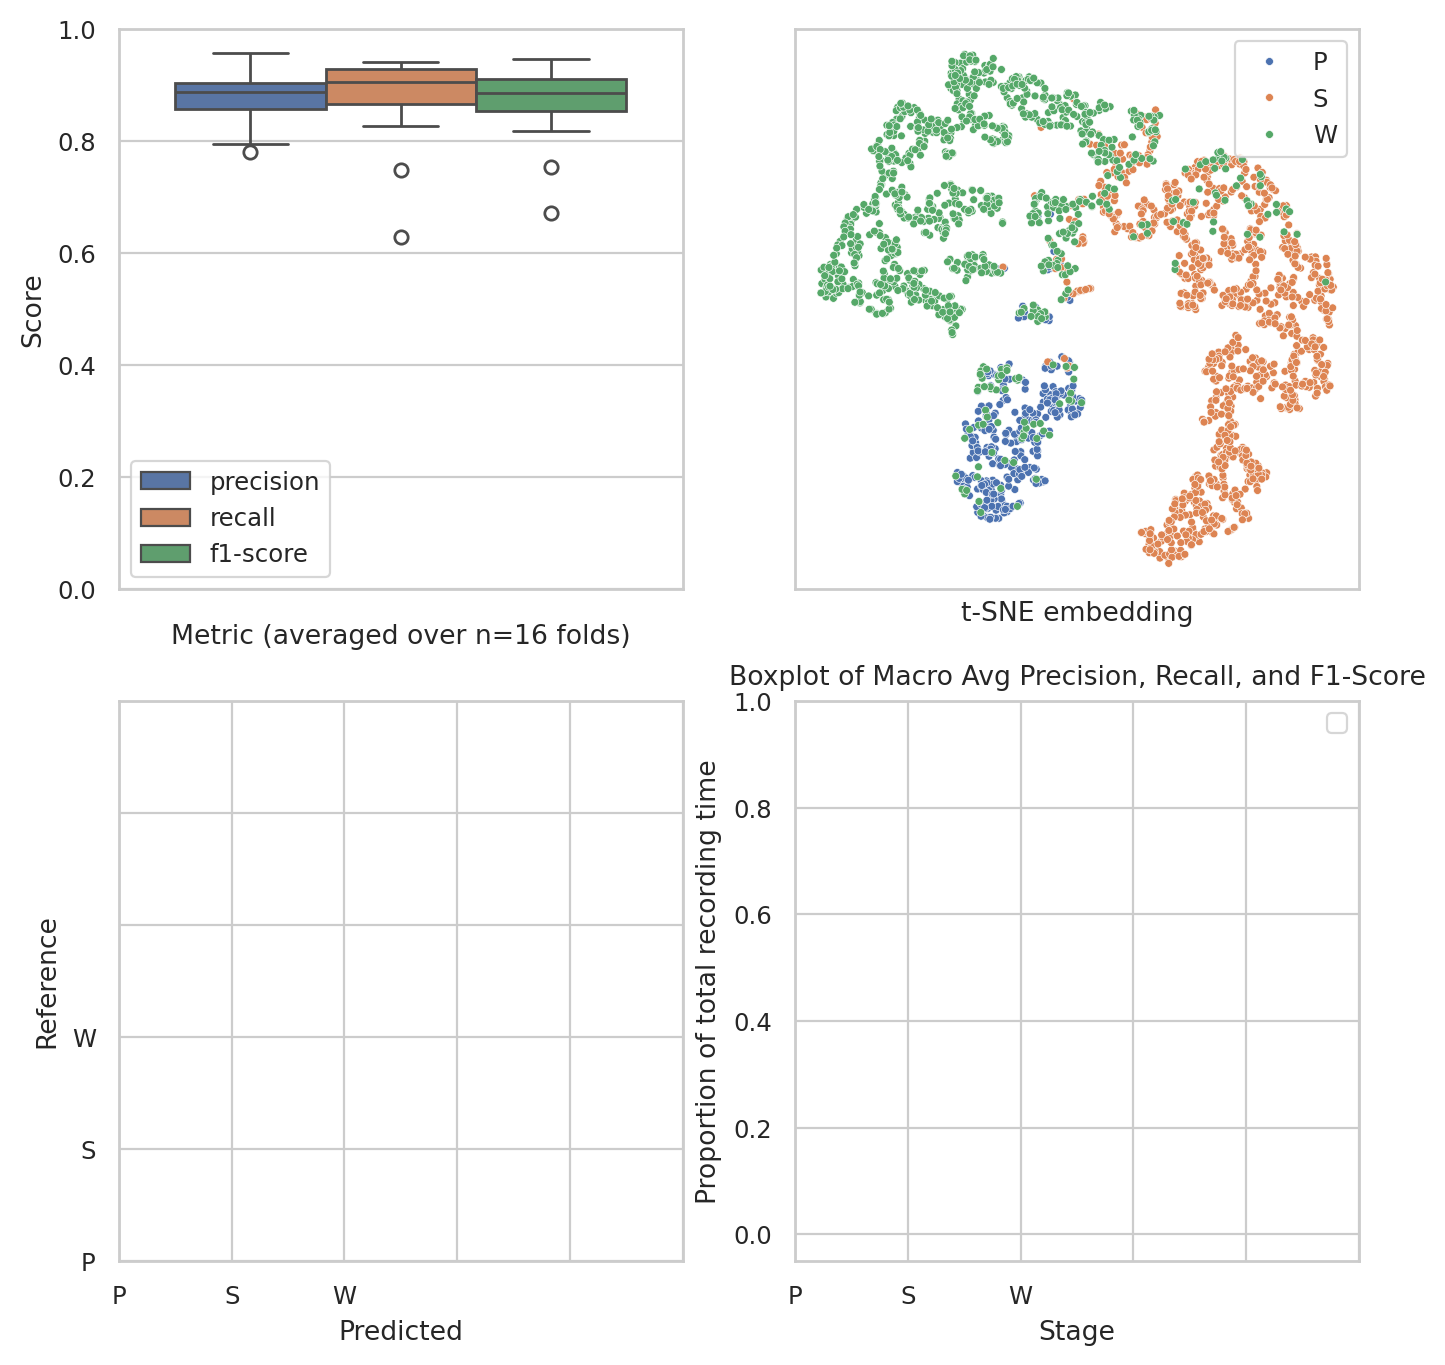

In [11]:
import seaborn as sns
sns.set_theme('paper')
sns.set_style('whitegrid')
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(8,8),dpi=200)
sns.scatterplot(data=tsne_df,x=0,y=1,hue='y',s=8,ax=axes[0,1])
sns.boxplot(hue='metric', y='value', data=long_df,ax=axes[0,0])
plt.title('Boxplot of Macro Avg Precision, Recall, and F1-Score')

axes[0,0].set_ylim(0,1)
axes[1,1].set_ylim(-.05,1)
axes[0,0].set_ylabel('Score')
axes[0,0].set_xlabel('Metric (averaged over n=16 folds)')
axes[1,0].set_xticklabels(labels=['P','S','W'])
axes[1,0].set_yticklabels(labels=['P','S','W'])
axes[1,1].set_xticklabels(labels=['P','S','W'])
axes[0,1].set_xlabel('t-SNE embedding')
axes[0,1].set_ylabel('')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Reference')
axes[1,1].set_xlabel('Stage')
axes[1,1].set(ylabel='Proportion of total recording time')
axes[0,0].legend()
axes[1,1].legend()
axes[0,1].legend()
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

plt.show()